In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [31]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Suicide_Detection.csv'

temp_df = pd.read_csv(dataset_path)

Mounted at /content/drive


In [8]:
df = temp_df.iloc[:40000]

Feature Selection

In [9]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)
df.head()

<ipython-input-9-10b64ef4bad3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0'],axis=1, inplace=True)


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


Check for null values or duplicate values

In [10]:
Null_value=df.isnull().sum()
dupli=df.duplicated().sum()
print("NUll: ",Null_value)
print("Duplicate: ",dupli)

NUll:  text     0
class    0
dtype: int64
Duplicate:  0


Class Distribution

In [11]:
# no imbalaced classes
df['class'].value_counts()

,count
class,
non-suicide,20076
suicide,19924


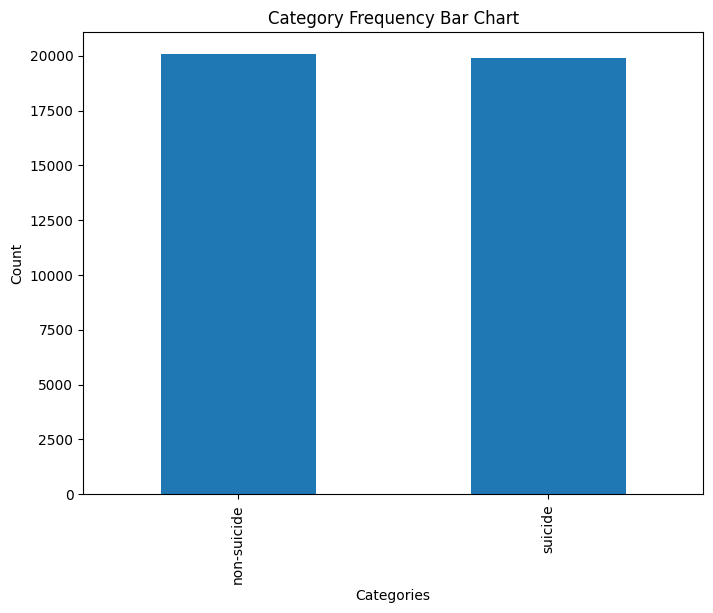

In [12]:
import matplotlib.pyplot as plt
# Plotting with Matplotlib
category_counts = df['class'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')

# Adding titles and labels
plt.title('Category Frequency Bar Chart')
plt.xlabel('Categories')
plt.ylabel('Count')

# Show plot
plt.show()

Creating wordcount column

In [13]:
# Function to calculate word count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

<ipython-input-13-1b6c61f783e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['text'].apply(lambda x: len(x.split()))


,text,class,word_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143
1,Am I weird I don't get affected by compliments...,non-suicide,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,26
3,i need helpjust help me im crying so hard,suicide,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,438


In [14]:
df['word_count'].describe()

,word_count
count,40000.000000
mean,130.577475
std,212.351000
min,1.000000
25%,26.000000
50%,61.000000
75%,154.000000
max,7514.000000


Checking for outliers

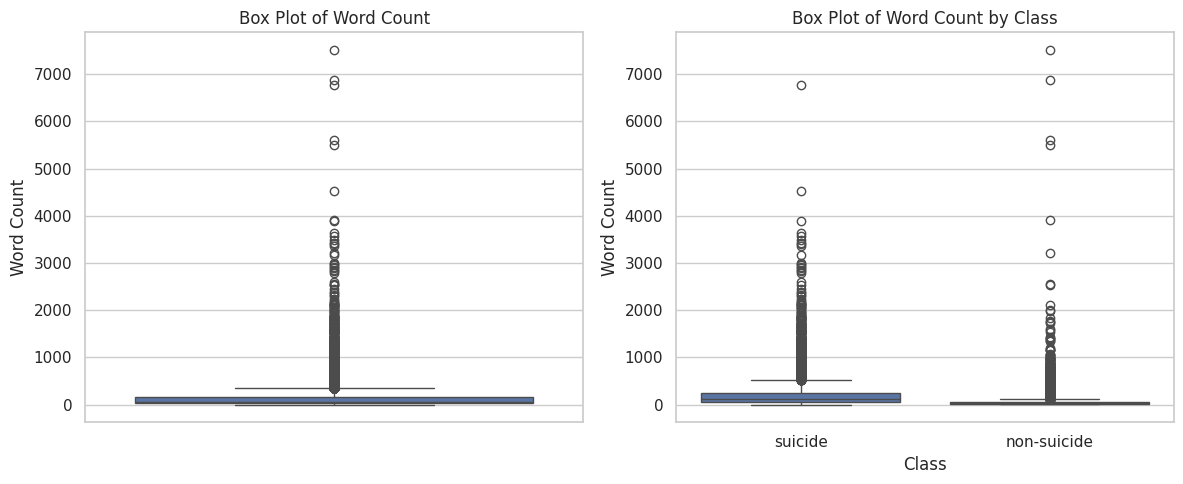

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the visualisation style
sns.set(style="whitegrid")

# Create the first box plot for word count
plt.figure(figsize=(12, 5))

# Box plot of word count
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(y=df['word_count'])
plt.title('Box Plot of Word Count')
plt.ylabel('Word Count')

# Create the second box plot for word count + class
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Box Plot of Word Count by Class')
plt.xlabel('Class')
plt.ylabel('Word Count')

# Show the plots
plt.tight_layout()
plt.show()

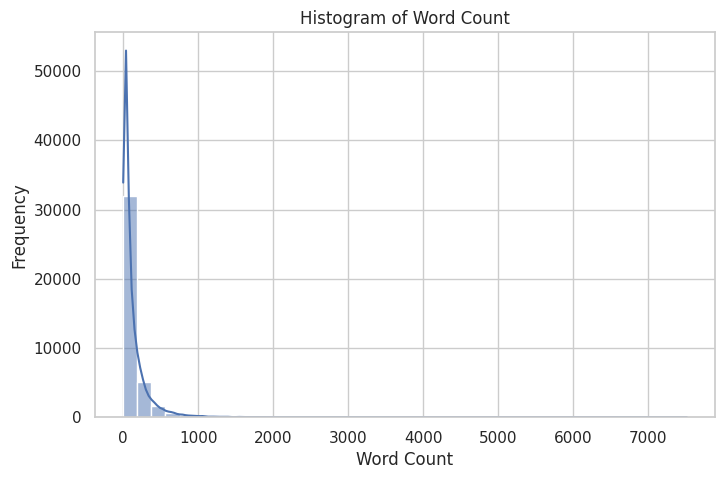

In [16]:
# Plot the histogram of word counts
plt.figure(figsize=(8, 5))
sns.histplot(df['word_count'], bins=40, kde=True)
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Removing Outlier[word count]

In [17]:
# As variance is high and between Q1 and Q3 only and data is not concern for us here rather then output.
# as too short or too long sentences create overfitting or underfitting.

# Calculate Q1 and Q3
P20 = df['word_count'].quantile(0.20)
P80 = df['word_count'].quantile(0.80)
print(P20,"and",P80)
# Define lower and upper bounds for filtering
lower_bound = P20
upper_bound = P80

# Filter the DataFrame to remove outliers
df = df[(df['word_count'] >= lower_bound) & (df['word_count'] <= upper_bound)]

df.head()

22.0 and 189.0


,text,class,word_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143
1,Am I weird I don't get affected by compliments...,non-suicide,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,26
10,I took the rest of my sleeping pills and my pa...,suicide,29
11,Can you imagine getting old? Me neither.Wrinkl...,suicide,74


In [18]:
df['word_count'].describe()

,word_count
count,24401.000000
mean,73.693168
std,45.484209
min,22.000000
25%,36.000000
50%,60.000000
75%,103.000000
max,189.000000


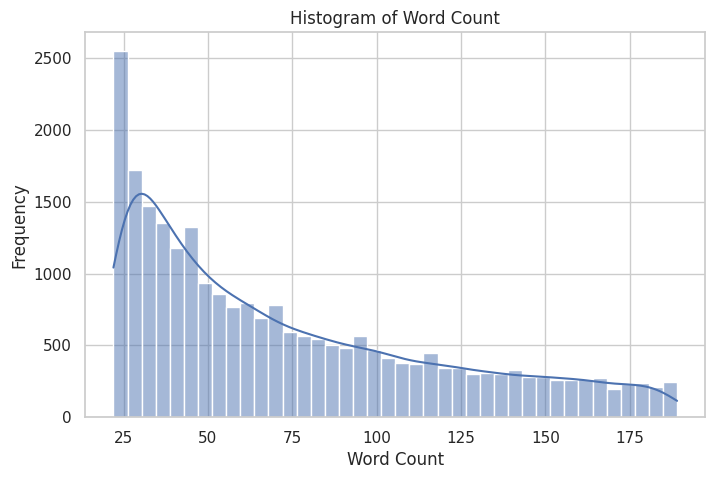

In [19]:
# Plot the histogram of word counts
plt.figure(figsize=(8, 5))
sns.histplot(df['word_count'], bins=40, kde=True)
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Reducing imbalance between 2 class with word count

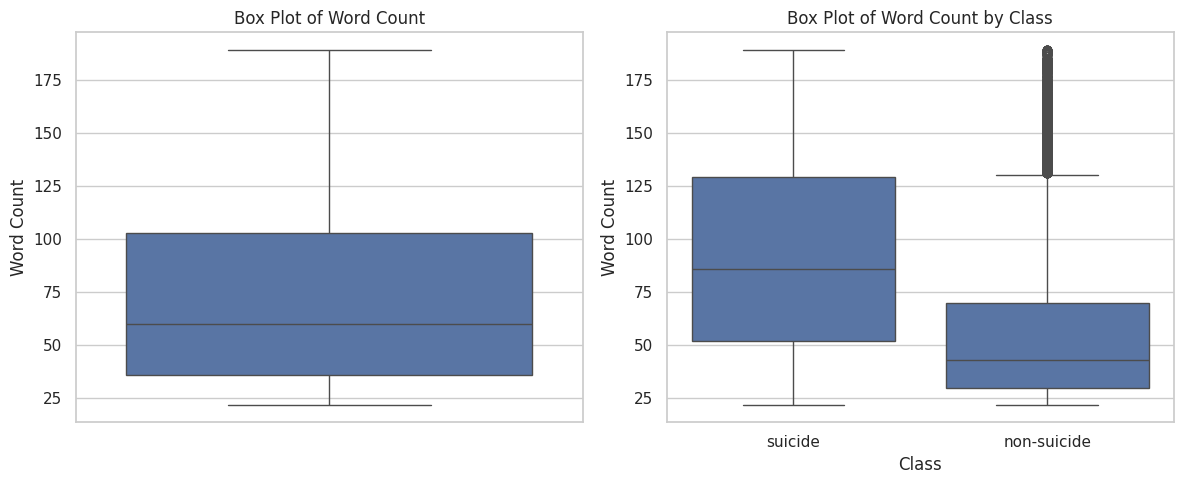

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the visualisation style
sns.set(style="whitegrid")

# Create the first box plot for word count
plt.figure(figsize=(12, 5))

# Box plot of word count
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(y=df['word_count'])
plt.title('Box Plot of Word Count')
plt.ylabel('Word Count')

# Create the second box plot for word count + class
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Box Plot of Word Count by Class')
plt.xlabel('Class')
plt.ylabel('Word Count')

# Show the plots
plt.tight_layout()
plt.show()

In [21]:
# Group by class and calculate summary statistics for word count
class_stats = df.groupby('class')['word_count'].describe()
# Print the class-wise statistics
print("Class-wise Word Count Statistics:")
print(class_stats)

Class-wise Word Count Statistics:
               count       mean        std   min   25%   50%    75%    max
class                                                                     
non-suicide  12619.0  56.333703  36.708190  22.0  30.0  43.0   70.0  189.0
suicide      11782.0  92.285860  46.616031  22.0  52.0  86.0  129.0  189.0


In [22]:
# Filter the dataset to include rows where word count is between 50 and 125 (inclusive)
df = df[(df['word_count'] >= 50) & (df['word_count'] <= 125)]
# Verify the class distribution after filtering
print("\nClass distribution after filtering:")
print(df['class'].value_counts())


Class distribution after filtering:
class
suicide        5980
non-suicide    4304
Name: count, dtype: int64


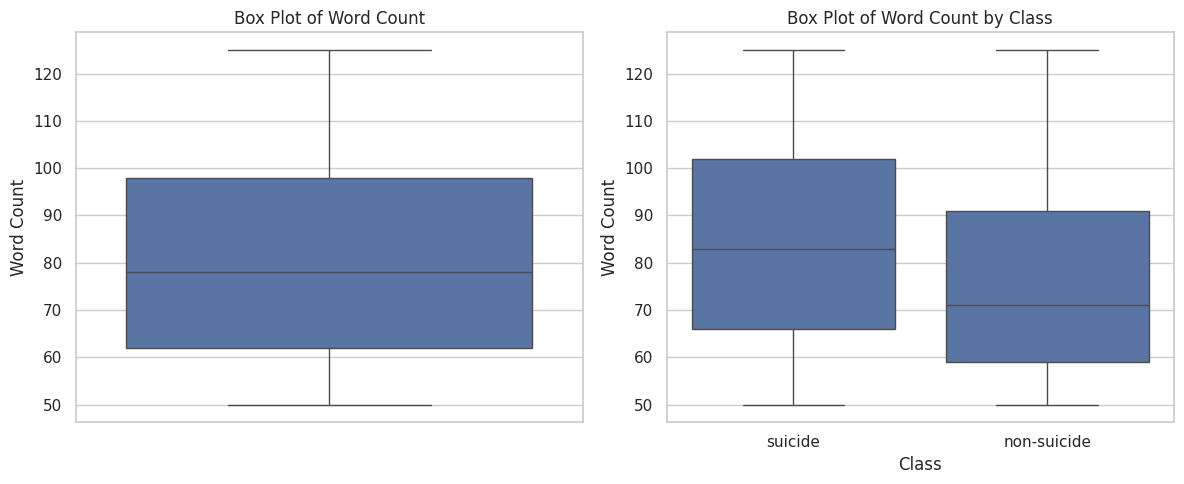

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the visualisation style
sns.set(style="whitegrid")

# Create the first box plot for word count
plt.figure(figsize=(12, 5))

# Box plot of word count
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(y=df['word_count'])
plt.title('Box Plot of Word Count')
plt.ylabel('Word Count')

# Create the second box plot for word count + class
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Box Plot of Word Count by Class')
plt.xlabel('Class')
plt.ylabel('Word Count')

# Show the plots
plt.tight_layout()
plt.show()

Balancing the suicide & non-suicide count

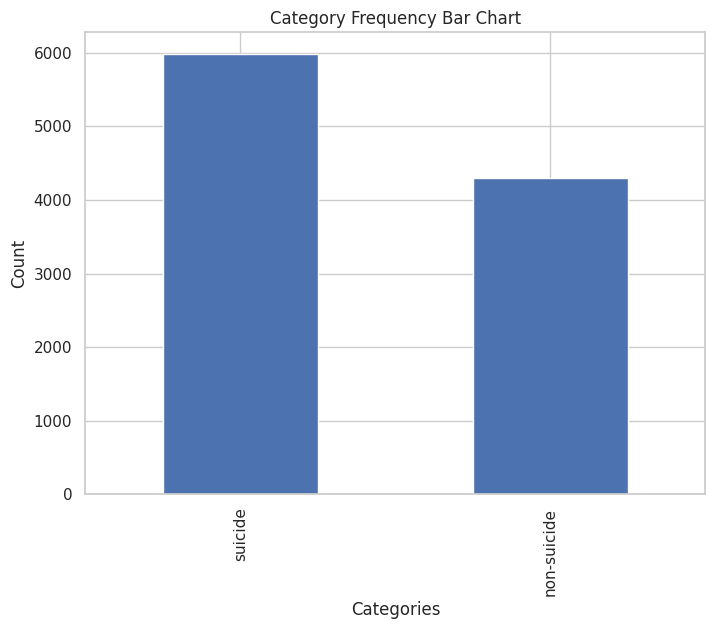

In [24]:
import matplotlib.pyplot as plt


# Plotting with Matplotlib
category_counts = df['class'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')

# Adding titles and labels
plt.title('Category Frequency Bar Chart')
plt.xlabel('Categories')
plt.ylabel('Count')

# Show plot
plt.show()

In [25]:
# Step 1: Separate classes
df_suicide = df[df['class'] == 'suicide']
df_non_suicide = df[df['class'] == 'non-suicide']

# Step 2: Balance each class to 2000 samples
df_suicide_balanced = df_suicide.sample(n=4304, random_state=42) if len(df_suicide) >= 4304 else df_suicide
df_non_suicide_balanced = df_non_suicide.sample(n=4304, random_state=42) if len(df_non_suicide) >= 4304 else df_non_suicide

# Step 3: Combine balanced classes
df_balanced = pd.concat([df_suicide_balanced, df_non_suicide_balanced])

# Shuffle the dataset to mix the classes
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 4: Plotting with Matplotlib
category_counts = df_balanced['class'].value_counts()

Final Visualization

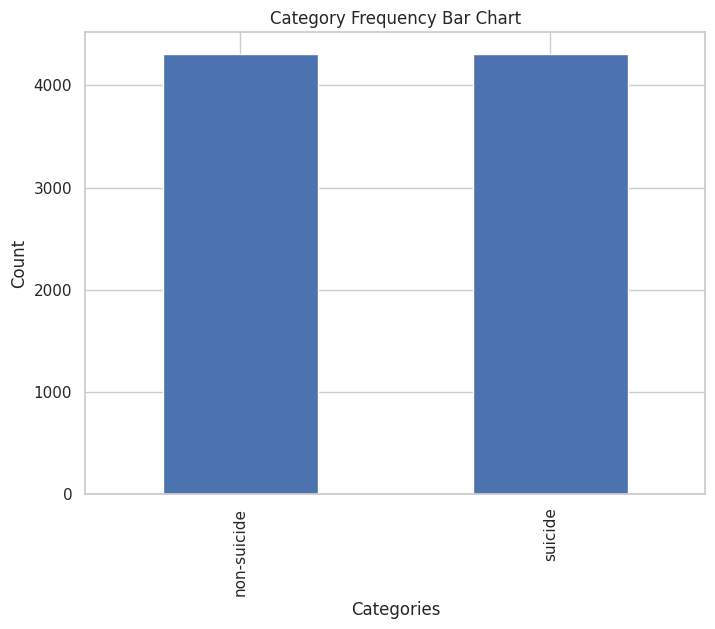

In [26]:
import matplotlib.pyplot as plt


# Plotting with Matplotlib
category_counts = df['class'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')

# Adding titles and labels
plt.title('Category Frequency Bar Chart')
plt.xlabel('Categories')
plt.ylabel('Count')

# Show plot
plt.show()

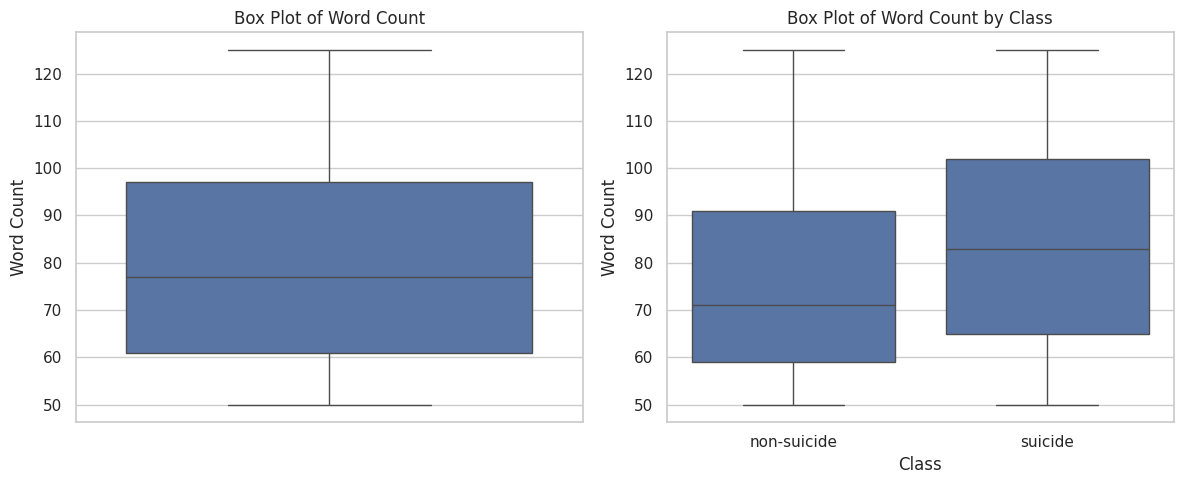

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the visualisation style
sns.set(style="whitegrid")

# Create the first box plot for word count
plt.figure(figsize=(12, 5))

# Box plot of word count
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(y=df['word_count'])
plt.title('Box Plot of Word Count')
plt.ylabel('Word Count')

# Create the second box plot for word count + class
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Box Plot of Word Count by Class')
plt.xlabel('Class')
plt.ylabel('Word Count')

# Show the plots
plt.tight_layout()
plt.show()

In [28]:
# Group by class and calculate summary statistics for word count
class_stats = df.groupby('class')['word_count'].describe()
# Print the class-wise statistics
print("Class-wise Word Count Statistics:")
print(class_stats)

Class-wise Word Count Statistics:
              count       mean        std   min   25%   50%    75%    max
class                                                                    
non-suicide  4304.0  75.986757  20.540490  50.0  59.0  71.0   91.0  125.0
suicide      4304.0  84.365474  21.812993  50.0  65.0  83.0  102.0  125.0


Data Preprocessing

Convert in Lower

In [29]:
df['text'] = df['text'].apply(lambda x : x.lower())
df.head()

,text,class,word_count
0,horny horns horny someone just dared me to edg...,non-suicide,50
1,waiting for the perfect momentwaiting for the ...,suicide,105
2,to those who care i’m just a dude who wants lo...,non-suicide,58
3,i just want to end it.i hate evrything about m...,suicide,60
4,it doesn't really matter if i'm here or not.th...,suicide,70


Remove punctuation

Remove stop words


Tokenize text


Clean tokens

In [32]:
# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Function to tokenize text
def tokenize(text):
    return word_tokenize(text)

# Additional cleaning: remove non-alphabetic tokens and convert to lowercase
def clean_tokens(tokens):
    return [word.lower() for word in tokens if word.isalpha()]

# Apply all steps: remove punctuation, tokenize, clean tokens, and remove stop words
df['text'] = df['text'].apply(
    lambda x: clean_tokens(remove_stopwords(tokenize(remove_punctuation(x))))
)

# Output the cleaned and tokenized DataFrame
df.head()

,text,class,word_count
0,"[horny, horns, horny, someone, dared, edge, th...",non-suicide,50
1,"[waiting, perfect, momentwaiting, first, rave,...",suicide,105
2,"[care, dude, wants, love, mean, hard, girls, t...",non-suicide,58
3,"[want, end, iti, hate, evrything, life, believ...",suicide,60
4,"[doesnt, really, matter, im, notthe, sun, stil...",suicide,70


Stemming

In [33]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

# Apply the cleaning functions and stemming to the 'tokenized_review' column
df['text'] = df['text'].apply(stem_tokens)

# Output the cleaned and stemmed DataFrame
df.head()

,text,class,word_count
0,"[horni, horn, horni, someon, dare, edg, three,...",non-suicide,50
1,"[wait, perfect, momentwait, first, rave, coron...",suicide,105
2,"[care, dude, want, love, mean, hard, girl, thi...",non-suicide,58
3,"[want, end, iti, hate, evryth, life, believ, m...",suicide,60
4,"[doesnt, realli, matter, im, notth, sun, still...",suicide,70


POS tagging   

accuracy decreases with it

In [34]:
# import nltk
# from nltk import word_tokenize, pos_tag

# # Download NLTK POS tagger and tokenizer if you haven't
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')


# # Define POS tags that are important for depression detection
# IMPORTANT_POS = {"JJ", "JJR", "JJS", "RB", "RBR", "RBS", "PRP", "PRP$", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}

# def filter_important_pos_nltk(text):


#     # Get POS tags for each token
#     tagged_tokens = pos_tag(text)

#     # Keep only tokens that have important POS tags


#     # Return filtered tokens as a string or a list
#     return [word for word, pos in tagged_tokens if pos in IMPORTANT_POS]


# df['text'] = df['text'].apply(
#     lambda x: filter_important_pos_nltk(x)
# )

# df.head()

Lemmetization

In [35]:
# from nltk.stem import WordNetLemmatizer
# import nltk

# # Download WordNet data if you haven't already
# nltk.download('wordnet')
# # Initialize the WordNet Lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Function to apply lemmatization
# def lemmatize_tokens(tokens):
#     return [lemmatizer.lemmatize(word) for word in tokens]

# # Apply the cleaning functions and lemmatization to the 'tokenized_review' column
# df['text'] = df['text'].apply(lemmatize_tokens)

# # Output the cleaned and lemmatized DataFrame
# df.head()

Join tokenized list

In [36]:
# Join the tokenized lists into strings for CountVectorizer
df['text'] = df['text'].apply(lambda tokens: ' '.join(tokens))
df.head()

,text,class,word_count
0,horni horn horni someon dare edg three time di...,non-suicide,50
1,wait perfect momentwait first rave corona shit...,suicide,105
2,care dude want love mean hard girl think guy w...,non-suicide,58
3,want end iti hate evryth life believ made abl ...,suicide,60
4,doesnt realli matter im notth sun still come t...,suicide,70


Model building

Devide dependent and independent

In [37]:
X = df.iloc[:,0:1]
y = df['class']
X

,text
0,horni horn horni someon dare edg three time di...
1,wait perfect momentwait first rave corona shit...
2,care dude want love mean hard girl think guy w...
3,want end iti hate evryth life believ made abl ...
4,doesnt realli matter im notth sun still come t...
...,...
8603,world kinda bore everyon live way wake brush t...
8604,fuck surgerymedicin free us fund entir govern ...
8605,peopl like cant post imagesss bro sin eye lord...
8606,cant seem shove feel anymorei keep think aw lo...


In [38]:
y

,class
0,non-suicide
1,suicide
2,non-suicide
3,suicide
4,suicide
...,...
8603,non-suicide
8604,non-suicide
8605,non-suicide
8606,suicide


Encode Category

In [39]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [40]:
#suicide=1, non-suicide=0
y

array([0, 1, 0, ..., 0, 1, 0])

Train Test Split

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [42]:
X_train.shape

(6886, 1)

In [43]:
# For unigrams and bigrams
cv2 = CountVectorizer(ngram_range=(1, 2), max_features=2000)  # This includes both unigrams and bigrams  #20000 overall accuracy increased
X_train_bow2 = cv2.fit_transform(X_train['text']).toarray()
X_test_bow2 = cv2.transform(X_test['text']).toarray()

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(X_train_bow2,y_train)
y_pred = rf.predict(X_test_bow2)
accuracy_score(y_test,y_pred)

0.8803716608594657

In [45]:
confusion_matrix(y_test,y_pred)

array([[748, 136],
       [ 70, 768]])

In [46]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.88
Precision: 0.85
Recall: 0.92
F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       884
           1       0.85      0.92      0.88       838

    accuracy                           0.88      1722
   macro avg       0.88      0.88      0.88      1722
weighted avg       0.88      0.88      0.88      1722



In [47]:
import pickle

# Save the model
with open('modelNew.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

# Save the vectorizer
with open('vectorizerNew.pkl', 'wb') as vectorizer_file:
    pickle.dump(cv2, vectorizer_file)  # Assuming 'cv2' is your vectorizer (CountVectorizer or TfidfVectorizer)